In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import xml.etree.ElementTree as ET

from xml.dom.minidom import parse
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

## Preparation

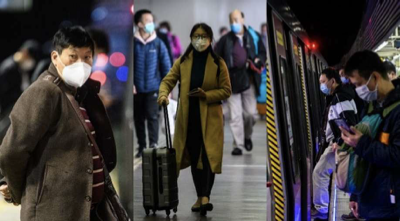

In [2]:
# dataset path
images_path = 'Datasets/face-mask-detection/images/'
annot_path = 'Datasets/face-mask-detection/annotations/'

# take image sample
sample_image_filename = np.random.choice(os.listdir(images_path))

image_sample = tf.keras.preprocessing.image.load_img(
    images_path + sample_image_filename
)
image_sample

In [3]:
# take annotation sample
# sample_annot_filename = np.random.choice(os.listdir(annot_path))
sample_annot_filename = sample_image_filename.replace('png', 'xml')

with open(annot_path + sample_annot_filename, 'r') as f:
    read_xml = f.read()

print(read_xml)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss376.png</filename>
    <size>
        <width>400</width>
        <height>221</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>58</xmin>
            <ymin>48</ymin>
            <xmax>94</xmax>
            <ymax>88</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>144</xmin>
            <ymin>17</ymin>
            <xmax>154</xmax>
            <ymax>33</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated

In [4]:
# traverse to get class name(s) and bounding box(es)
tree = ET.parse(annot_path + sample_annot_filename)
root = tree.getroot()

sample_annot = []

for neighbor in root.iter('object'):
    print(neighbor.find('name').text)
    
for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
    
    sample_annot.append([xmin, ymin, xmax, ymax])
    
print(sample_annot)

with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
[[58, 48, 94, 88], [144, 17, 154, 33], [191, 29, 210, 51], [229, 15, 242, 31], [318, 77, 330, 94], [338, 72, 349, 84], [350, 79, 377, 102]]


In [5]:
# version 2: traverse to get class name and bounding box
tree = ET.parse(annot_path + sample_annot_filename)
root = tree.getroot()

object_element = root.findall('object')[0]
curr_class = object_element.find('name').text
bndbox_element = object_element.find('bndbox')
xmin = int(bndbox_element.find('xmin').text)
ymin = int(bndbox_element.find('ymin').text)
xmax = int(bndbox_element.find('xmax').text)
ymax = int(bndbox_element.find('ymax').text)

sample_annot.append([xmin, ymin, xmax, ymax])

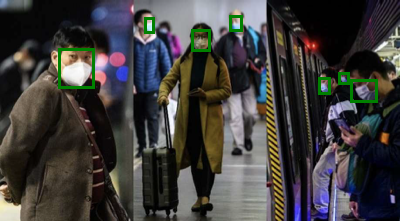

In [6]:
img_ = ImageDraw.Draw(image_sample)

for bndbox in sample_annot:
    img_.rectangle(bndbox, outline='green', width=3)
image_sample

In [7]:
# traverse through image and annotation files
labels = []
img_data = np.array([])
img_names = []
img_paths = []
bndboxes = []

# for each annotation file
for annot_filename in tqdm(os.listdir(annot_path)):
    # get xml and png file path
    img_name = annot_filename.replace('.xml', '')
    xml_file_path = annot_path + annot_filename
    png_file_path = (images_path + annot_filename).replace('xml', 'png')
    
    # load the image to array
    img = tf.keras.preprocessing.image.load_img(png_file_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # parse the xml file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # check if image contains more than one person
    object_elements = root.findall('object')
    if len(object_elements) == 1:
        # get image size to help rescaling later
        size_element = root.find('size')
        curr_width = int(size_element.find('width').text)
        curr_height = int(size_element.find('height').text)

        # get label
        object_element = object_elements[0]
        curr_label = object_element.find('name').text
        
        # get bounding box and rescale to 0 - 1
        bndbox_element = object_element.find('bndbox')
        xmin = int(bndbox_element.find('xmin').text) / curr_width
        ymin = int(bndbox_element.find('ymin').text) / curr_height
        xmax = int(bndbox_element.find('xmax').text) / curr_width
        ymax = int(bndbox_element.find('ymax').text) / curr_height
        curr_bndbox = np.array([[xmin, ymin, xmax, ymax]], dtype=np.float32)

        # append current image array, filename, path, label, and bounding box
        labels.append(curr_label)
        resized_img_array = tf.image.resize([img_array], [224,224]).numpy()[0]
        
        if len(img_data) == 0: 
            img_data = np.expand_dims(resized_img_array, axis=0)
        else:
            img_data = np.append(img_data, np.expand_dims(resized_img_array, axis=0), axis=0)
            
        img_names.append(img_name)
        img_paths.append(png_file_path)
        bndboxes.append(curr_bndbox)

  0%|          | 0/853 [00:00<?, ?it/s]

Metal device set to: Apple M1


2021-11-30 13:29:47.197372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-30 13:29:47.197974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


with_mask
Datasets/face-mask-detection/images/maksssksksss37.png


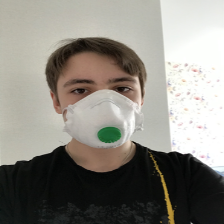

In [8]:
rand_n = np.random.randint(0, len(labels))
print(labels[rand_n])
print(img_paths[rand_n])
tf.keras.preprocessing.image.array_to_img(img_data[rand_n])

In [9]:
# label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# train test split
splits = train_test_split(
    img_data, encoded_labels, bndboxes, img_paths,
    test_size=0.2, random_state=22, stratify=encoded_labels
)

train_images, test_images = splits[:2]
train_labels, test_labels = splits[2:4]
train_boxes, test_boxes = splits[4:6]
train_paths, test_paths = splits[6:]

In [10]:
class_names = label_encoder.classes_
print(class_names)

['mask_weared_incorrect' 'with_mask' 'without_mask']


In [11]:
np.unique(encoded_labels, return_counts=True)

(array([0, 1, 2]), array([ 21, 256,  52]))

In [12]:
# pass the image arrays to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, (train_labels, train_boxes))
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_images, (test_labels, test_boxes))
)

## Model Training

### Xception

In [13]:
# define the model with Xception
n_classes = len(np.unique(train_labels))
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet', include_top=False
)
avg_pool = tf.keras.layers.GlobalAveragePooling2D()(
    base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation='softmax', name='class_output')(avg_pool)
loc_output = tf.keras.layers.Dense(4, name='loc_output')(avg_pool)
model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[class_output, loc_output]
)

model.compile(
    loss=['sparse_categorical_crossentropy', 'mae'],
    loss_weights=[0.8, 0.2],
    optimizer='sgd', metrics=['accuracy', 'mae']
)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [15]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100

train_dataset_batched = train_dataset.shuffle(
    SHUFFLE_BUFFER_SIZE
).batch(BATCH_SIZE)

test_dataset_batched = test_dataset.batch(BATCH_SIZE)

In [16]:
model.fit(train_dataset_batched, epochs=30, validation_data=test_dataset_batched)

Epoch 1/30


2021-11-30 13:30:25.120185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-30 13:30:25.129134: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-30 13:30:25.129731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.6497 - class_output_loss: 0.6993 - loc_output_loss: 0.4509 - class_output_accuracy: 0.7490 - class_output_mae: 0.8010 - loc_output_accuracy: 0.2625 - loc_output_mae: 0.4529

2021-11-30 13:30:43.846963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 21s 1s/step - loss: 0.6497 - class_output_loss: 0.6993 - loc_output_loss: 0.4509 - class_output_accuracy: 0.7490 - class_output_mae: 0.8010 - loc_output_accuracy: 0.2625 - loc_output_mae: 0.4529 - val_loss: 0.8240 - val_class_output_loss: 0.9388 - val_loc_output_loss: 0.3650 - val_class_output_accuracy: 0.7727 - val_class_output_mae: 0.8131 - val_loc_output_accuracy: 0.2928 - val_loc_output_mae: 0.3666
Epoch 2/30
17/17 [==============================] - 19s 1s/step - loss: 0.4417 - class_output_loss: 0.4753 - loc_output_loss: 0.3071 - class_output_accuracy: 0.7795 - class_output_mae: 0.8010 - loc_output_accuracy: 0.3445 - loc_output_mae: 0.3080 - val_loss: 0.8330 - val_class_output_loss: 0.9311 - val_loc_output_loss: 0.4409 - val_class_output_accuracy: 0.7727 - val_class_output_mae: 0.8131 - val_loc_output_accuracy: 0.3006 - val_loc_output_mae: 0.4419
Epoch 3/30
17/17 [==============================] - 19s 1s/step - loss: 0.3689 - class_output_l

In [17]:
pd.DataFrame(model.history.history)

,loss,class_output_loss,loc_output_loss,class_output_accuracy,class_output_mae,loc_output_accuracy,loc_output_mae,val_loss,val_class_output_loss,val_loc_output_loss,val_class_output_accuracy,val_class_output_mae,val_loc_output_accuracy,val_loc_output_mae
0,0.649668,0.699348,0.450946,0.749049,0.801014,0.262485,0.452872,0.824041,0.938804,0.364993,0.772727,0.813131,0.292802,0.366568
1,0.441667,0.475310,0.307095,0.779468,0.801014,0.344511,0.308025,0.833015,0.931055,0.440858,0.772727,0.813131,0.300584,0.441886
2,0.368856,0.393605,0.269864,0.787072,0.801014,0.387214,0.270815,0.675587,0.732980,0.446013,0.772727,0.813131,0.357004,0.442606
3,0.312239,0.325192,0.260424,0.847909,0.801014,0.417853,0.259717,0.639568,0.695545,0.415661,0.772727,0.813131,0.434825,0.411057
4,0.278446,0.285761,0.249187,0.882129,0.801014,0.440048,0.249235,0.577000,0.624807,0.385774,0.787879,0.813131,0.383268,0.381367
5,0.240829,0.241313,0.238891,0.927757,0.801014,0.440290,0.239415,0.537988,0.583235,0.357002,0.818182,0.813131,0.422179,0.352644
6,0.219774,0.215867,0.235398,0.942966,0.801014,0.442461,0.235739,0.499110,0.539114,0.339092,0.848485,0.813131,0.428016,0.334642
7,0.189540,0.183154,0.215086,0.946768,0.801014,0.461761,0.215217,0.452320,0.484084,0.325263,0.924242,0.813131,0.451362,0.320840
8,0.168452,0.157358,0.212828,0.954373,0.801014,0.475030,0.212525,0.425189,0.455014,0.305891,0.924242,0.813131,0.466926,0.301672
9,0.150996,0.135624,0.212484,0.961977,0.801014,0.467310,0.212859,0.405567,0.434362,0.290387,0.939394,0.813131,0.459144,0.286191


2021-11-30 13:39:41.566726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


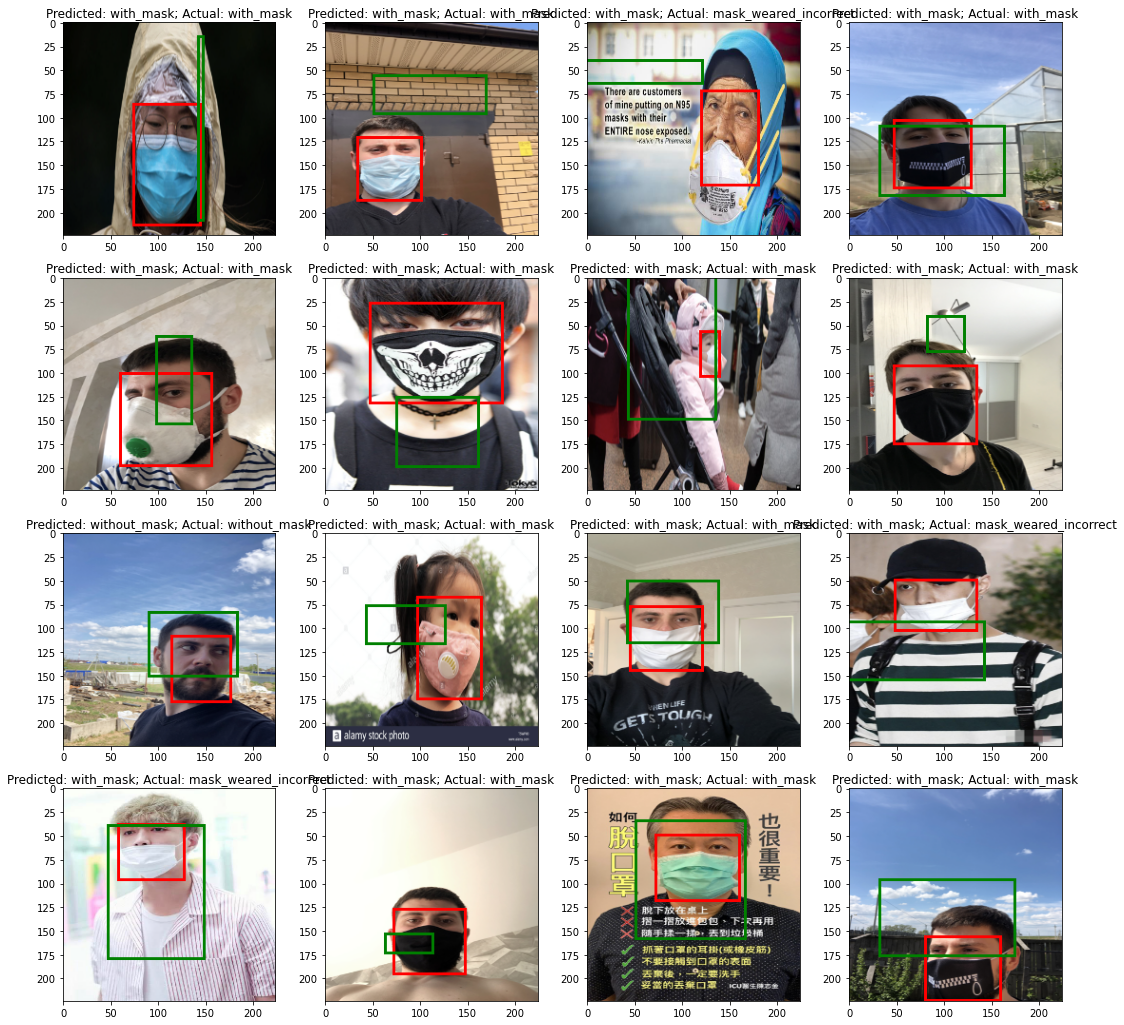

In [18]:
# predict a batch of test data
test_single_batch = test_dataset_batched.take(1)
predicted = model.predict(test_single_batch)
predicted_classes = np.argmax(predicted[0], axis=1)
predicted_boxes = predicted[1]

fig, ax = plt.subplots(4, 4, figsize=(18,18))

# TODO: revert the original image size before drawing prediction result
for single_data in test_single_batch.as_numpy_iterator():
    # split the batches into images arrays, labels, and boxes
    batch_image_array = single_data[0]
    batch_labels = single_data[1][0]
    batch_boxes = single_data[1][1]
    
    for ix in range(len(batch_image_array)):
        single_image = tf.keras.preprocessing.image.array_to_img(batch_image_array[ix])
        single_image_label = batch_labels[ix]
        single_image_box = batch_boxes[ix]
        single_image_label_pred = predicted_classes[ix]
        single_image_box_pred = predicted_boxes[ix]
        
        single_image_drawn = ImageDraw.Draw(single_image)
        single_image_drawn.rectangle(single_image_box * 224, outline='red', width=3)
        single_image_drawn.rectangle(single_image_box_pred * 224, outline='green', width=3)
        
        ax.flatten()[ix].imshow(single_image)
        ax.flatten()[ix].title.set_text(
            'Predicted: {}; Actual: {}'.format(
                class_names[single_image_label_pred],
                class_names[single_image_label]
            )
        )